In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors
import time

import numpy as np
import DataPreprocessing
import SmartPolynomials
import SplitDataSet

In [3]:
def transform(me):
    return np.multiply(np.sign(me), np.power(abs(me), 0.5))
def inverse(temp):
    return np.multiply(np.sign(temp), np.power(abs(temp), 1/0.5))
def inverse_tf(temp):
    return tf.multiply(tf.sign(temp), tf.pow(tf.abs(temp), 1/0.5)) 
def frac_error(true, experimental):
    return np.abs(np.divide(inverse(true) - inverse(experimental), inverse(true)))

In [4]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(inverse_tf(true) - inverse_tf(experimental), inverse_tf(true)))

def build_model(components=50, activation='relu'):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(50, activation='elu', input_shape=[12]), #could try swish??  
        keras.layers.Dense(100, activation='elu'),
        keras.layers.Dense(100, activation='elu'),
        keras.layers.Dense(50, activation='elu'),
        
        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape', perc_error])
    return model

In [5]:
def calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("NLO/MODEL/uuuxux.hdf5")
    else:
        model = build_model()
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

    # Callback for printing the LR at the end of each epoch.
    class PrintLR(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 10 == 0:
                temp_predict = self.model.predict(poly_test)
                temp_predict.shape = (len(temp_predict))
                error = 100*np.mean(born_error(temp_test, temp_predict, temp_test))
                print('\nPercentage error : {}'.format(error))
    
        # Saves the best model's weights
    checkpoint_path = "NLO/MODEL/uuuxux.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    tic = time.perf_counter()
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=5000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test))
    toc = time.perf_counter()
    print(f"Training ran in {toc - tic:0.4f} seconds")

    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))     
        train_error = 100*np.mean(frac_error(temp_train, train_predict))                                 
        
        tic = time.perf_counter()
        test_predict = saved_model.predict(poly_test)
        toc = time.perf_counter()
        print(f"Prediction ran in {toc - tic:0.4f} seconds")
        
        test_predict.shape = (len(test_predict))
        test_error = 100*np.mean(frac_error(temp_test, test_predict))

        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        
        np.save('NLO/uuuxux/pred_nn.npy', test_predict)
        np.save('NLO/uuuxux/test_nn.npy', test_predict)
        #return(train_error, test_error, born_error(temp_test, test_predict, rescaled_test[:,0]), history)
        return(train_error, test_error, (temp_test - test_predict)**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [6]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 1)


me_tr_0, mom_tr_0 = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 2)
mom_tr_0[:,[2,3]] = mom_tr_0[:,[3,2]]

me_te_0, mom_te_0 = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 2)
mom_te_0[:,[2,3]] = mom_te_0[:,[3,2]]


me_tr_1, mom_tr_1 = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 3)
mom_tr_1[:,[0,1]] = mom_tr_1[:,[1,0]]

me_te_1, mom_te_1 = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 3)
mom_te_1[:,[0,1]] = mom_te_1[:,[1,0]]


me_tr_2, mom_tr_2 = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 4)
mom_tr_2[:,[0,1,2,3]] = mom_tr_2[:,[1,0,3,2]]

me_te_2, mom_te_2 = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 4)
mom_te_2[:,[0,1,2,3]] = mom_te_2[:,[1,0,3,2]]


mom_train = np.concatenate([mom_train, mom_tr_0, mom_tr_1, mom_tr_2],axis=0)
me_train = np.concatenate([me_train, me_tr_0, me_tr_1, me_tr_2],axis=0)

mom_test = np.concatenate([mom_test, mom_te_0, mom_te_1, mom_te_2],axis=0)
me_test = np.concatenate([me_test, me_te_0, me_te_1, me_te_2],axis=0)

Split ran in 2.7386 seconds
Split ran in 1.2458 seconds
Split ran in 2.6965 seconds
Split ran in 1.2704 seconds
Split ran in 2.6222 seconds
Split ran in 1.2700 seconds
Split ran in 2.5095 seconds
Split ran in 1.3063 seconds


In [6]:
me_train, mom_train = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 0)
me_test, mom_test = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 0)

me_tr, mom_tr = SplitDataSet.smallestS('NLO/uuuxux/me_1000000.npy', 'NLO/uuuxux/mom_1000000.npy', 5)
mom_tr[:,[0,1,2,3]] = mom_tr[:,[2,3,0,1]]

me_te, mom_te = SplitDataSet.smallestS('NLO/uuuxux/me_500000.npy', 'NLO/uuuxux/mom_500000.npy', 5)
mom_te[:,[0,1,2,3]] = mom_te[:,[2,3,0,1]]


mom_train = np.concatenate([mom_train, mom_tr],axis=0)
me_train = np.concatenate([me_train, me_tr],axis=0)

mom_test = np.concatenate([mom_test, mom_te],axis=0)
me_test = np.concatenate([me_test, me_te],axis=0)

Split ran in 2.5721 seconds
Split ran in 1.2082 seconds
Split ran in 2.9377 seconds
Split ran in 1.2712 seconds


In [7]:
combs = ['1,3','2,3','1,4','2,4','1,2,3','1,2,4','1,3,4','2,3,4']

tic = time.perf_counter()
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_train))
temp_train = np.multiply(div_train[:,np.newaxis], me_train)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

tic = time.perf_counter()
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_test))
temp_test = np.multiply(div_test[:,np.newaxis], me_test)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

Test multiplication ran in 0.9822 seconds
Test multiplication ran in 0.3321 seconds


In [8]:
print('Std : {}'.format(np.std(temp_train[:,1])))
print('Mean : {}'.format(np.mean(temp_train[:,1])))

std = np.std(temp_train[:,1])
temp_train = transform(temp_train[:,1]/std)
temp_test = transform(temp_test[:,1]/std)

train, test, perc, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=False)

Std : 3.9305298071606364e+30
Mean : 3.2498676077932233e+30
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 666968 samples, validate on 332818 samples
Epoch 1/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.1227 - mean_absolute_percentage_error: 55.2834 - perc_error: 628.2463 - val_loss: 0.0900 - val_mean_absolute_percentage_error: 50.4746 - val_perc_error: 381.0838

Epoch 2/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0730 - mean_absolute_percentage_error: 45.1433 - perc_error: 339.9951 - val_loss: 0.0670 - val_mean_absolute_percentage_error: 43.4991 - val_perc_error: 262.2277

Epoch 3/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0640 - mean_absolute_percentage_error: 42.0721 - perc_error: 519.2923 - val_loss: 0.0581 - val_

666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0183 - mean_absolute_percentage_error: 21.0549 - perc_error: 78.1783 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 21.1739 - val_perc_error: 71.7792

Epoch 28/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0180 - mean_absolute_percentage_error: 20.8751 - perc_error: 75.4468 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 20.8642 - val_perc_error: 62.4338

Epoch 29/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0179 - mean_absolute_percentage_error: 20.7933 - perc_error: 77.1213 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 19.5340 - val_perc_error: 69.1512

Epoch 30/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0


Epoch 55/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0131 - mean_absolute_percentage_error: 17.9235 - perc_error: 68.8490 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 17.6969 - val_perc_error: 60.8110

Epoch 56/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0130 - mean_absolute_percentage_error: 17.7343 - perc_error: 63.1821 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 18.3412 - val_perc_error: 63.2368

Epoch 57/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0128 - mean_absolute_percentage_error: 17.6792 - perc_error: 63.1908 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 17.0219 - val_perc_error: 48.7155

Epoch 58/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us


Epoch 83/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0106 - mean_absolute_percentage_error: 16.4567 - perc_error: 55.7597 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 16.2506 - val_perc_error: 46.9393

Epoch 84/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0105 - mean_absolute_percentage_error: 16.4145 - perc_error: 54.2790 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 16.4621 - val_perc_error: 55.9184

Epoch 85/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0104 - mean_absolute_percentage_error: 16.3750 - perc_error: 58.4506 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 16.3055 - val_perc_error: 51.2058

Epoch 86/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us


Epoch 111/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0093 - mean_absolute_percentage_error: 15.6714 - perc_error: 51.3852 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 15.5537 - val_perc_error: 43.0577

Epoch 112/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0092 - mean_absolute_percentage_error: 15.6263 - perc_error: 53.8091 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 16.2207 - val_perc_error: 54.8550

Epoch 113/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0093 - mean_absolute_percentage_error: 15.5368 - perc_error: 45.2041 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 15.5334 - val_perc_error: 43.6380

Epoch 114/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 139/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0085 - mean_absolute_percentage_error: 15.0649 - perc_error: 44.9339 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 15.5186 - val_perc_error: 43.2130

Epoch 140/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0084 - mean_absolute_percentage_error: 15.0299 - perc_error: 47.2077 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 15.3053 - val_perc_error: 45.0535

Epoch 141/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0084 - mean_absolute_percentage_error: 15.0436 - perc_error: 49.6428 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 15.1755 - val_perc_error: 44.3395

Epoch 142/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 167/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0079 - mean_absolute_percentage_error: 14.6233 - perc_error: 44.6414 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 15.3240 - val_perc_error: 46.5400

Epoch 168/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0078 - mean_absolute_percentage_error: 14.5593 - perc_error: 43.9254 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 14.4178 - val_perc_error: 39.2428

Epoch 169/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0077 - mean_absolute_percentage_error: 14.5398 - perc_error: 47.1755 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 14.9172 - val_perc_error: 41.8789

Epoch 170/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 195/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0073 - mean_absolute_percentage_error: 14.1847 - perc_error: 44.2701 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 13.9257 - val_perc_error: 37.1504

Epoch 196/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0072 - mean_absolute_percentage_error: 14.2107 - perc_error: 46.3275 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 14.5655 - val_perc_error: 43.0340

Epoch 197/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0072 - mean_absolute_percentage_error: 14.0820 - perc_error: 42.6489 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 15.3090 - val_perc_error: 45.2010

Epoch 198/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 223/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0068 - mean_absolute_percentage_error: 13.8170 - perc_error: 40.4580 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 14.2652 - val_perc_error: 36.8904

Epoch 224/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0068 - mean_absolute_percentage_error: 13.7684 - perc_error: 42.0431 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 14.8751 - val_perc_error: 37.9499

Epoch 225/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0068 - mean_absolute_percentage_error: 13.7595 - perc_error: 39.6323 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 14.8936 - val_perc_error: 43.2941

Epoch 226/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1


Epoch 251/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0065 - mean_absolute_percentage_error: 13.4526 - perc_error: 37.6943 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 13.8737 - val_perc_error: 41.8290

Epoch 252/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0065 - mean_absolute_percentage_error: 13.4750 - perc_error: 39.6085 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 13.7866 - val_perc_error: 37.9517

Epoch 253/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0064 - mean_absolute_percentage_error: 13.4502 - perc_error: 42.8575 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 14.9829 - val_perc_error: 44.3270

Epoch 254/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 279/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0062 - mean_absolute_percentage_error: 13.2230 - perc_error: 47.8673 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 13.7991 - val_perc_error: 36.8177

Epoch 280/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0061 - mean_absolute_percentage_error: 13.1930 - perc_error: 39.2210 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 13.3176 - val_perc_error: 35.3555

Epoch 281/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0061 - mean_absolute_percentage_error: 13.1350 - perc_error: 43.0888 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 13.5181 - val_perc_error: 37.4124

Epoch 282/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 307/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0059 - mean_absolute_percentage_error: 12.9063 - perc_error: 37.5107 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 13.9048 - val_perc_error: 45.3928

Epoch 308/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0060 - mean_absolute_percentage_error: 12.9212 - perc_error: 35.5214 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 13.2115 - val_perc_error: 41.1331

Epoch 309/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0060 - mean_absolute_percentage_error: 12.9408 - perc_error: 36.0702 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 13.5003 - val_perc_error: 42.1660

Epoch 310/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 335/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0057 - mean_absolute_percentage_error: 12.7160 - perc_error: 39.6067 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 12.7025 - val_perc_error: 41.6714

Epoch 336/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0057 - mean_absolute_percentage_error: 12.6387 - perc_error: 37.6495 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 13.1429 - val_perc_error: 49.3453

Epoch 337/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0057 - mean_absolute_percentage_error: 12.7341 - perc_error: 35.5510 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 13.4197 - val_perc_error: 38.4551

Epoch 338/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 363/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0055 - mean_absolute_percentage_error: 12.5170 - perc_error: 35.6777 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 12.3652 - val_perc_error: 36.2581

Epoch 364/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0056 - mean_absolute_percentage_error: 12.5353 - perc_error: 35.2025 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 12.7412 - val_perc_error: 40.8456

Epoch 365/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0055 - mean_absolute_percentage_error: 12.5740 - perc_error: 41.9114 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 13.2346 - val_perc_error: 41.0212

Epoch 366/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 391/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0054 - mean_absolute_percentage_error: 12.4127 - perc_error: 37.7704 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 12.6957 - val_perc_error: 35.2576

Epoch 392/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0054 - mean_absolute_percentage_error: 12.3949 - perc_error: 34.3230 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 12.6290 - val_perc_error: 34.6517

Epoch 393/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0053 - mean_absolute_percentage_error: 12.2343 - perc_error: 31.9553 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 12.2994 - val_perc_error: 40.8523

Epoch 394/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1


Epoch 419/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0051 - mean_absolute_percentage_error: 12.1241 - perc_error: 35.1844 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 12.4664 - val_perc_error: 34.8720

Epoch 420/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0053 - mean_absolute_percentage_error: 12.2077 - perc_error: 34.9825 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 12.9822 - val_perc_error: 46.2928

Epoch 421/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0052 - mean_absolute_percentage_error: 12.1869 - perc_error: 38.1911 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 12.7743 - val_perc_error: 39.8487

Epoch 422/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 447/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0051 - mean_absolute_percentage_error: 12.0510 - perc_error: 34.3555 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.9222 - val_perc_error: 41.4669

Epoch 448/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0051 - mean_absolute_percentage_error: 12.0730 - perc_error: 41.8756 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 12.0436 - val_perc_error: 34.3795

Epoch 449/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0051 - mean_absolute_percentage_error: 12.0477 - perc_error: 32.4426 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.4222 - val_perc_error: 36.9244

Epoch 450/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 475/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0050 - mean_absolute_percentage_error: 11.9475 - perc_error: 38.2608 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.8761 - val_perc_error: 42.3501

Epoch 476/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0049 - mean_absolute_percentage_error: 11.9095 - perc_error: 33.8001 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 12.1147 - val_perc_error: 37.1097

Epoch 477/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0050 - mean_absolute_percentage_error: 11.9390 - perc_error: 36.2737 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 13.0190 - val_perc_error: 38.5785

Epoch 478/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 503/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0049 - mean_absolute_percentage_error: 11.7666 - perc_error: 40.5846 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 12.1791 - val_perc_error: 34.1668

Epoch 504/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0049 - mean_absolute_percentage_error: 11.7504 - perc_error: 32.1067 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 12.7106 - val_perc_error: 39.7877

Epoch 505/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0050 - mean_absolute_percentage_error: 11.8771 - perc_error: 48.9563 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 13.2458 - val_perc_error: 42.4994

Epoch 506/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 531/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0048 - mean_absolute_percentage_error: 11.7234 - perc_error: 39.5300 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 12.0777 - val_perc_error: 34.0959

Epoch 532/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0048 - mean_absolute_percentage_error: 11.6214 - perc_error: 32.3934 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.7400 - val_perc_error: 34.8482

Epoch 533/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0047 - mean_absolute_percentage_error: 11.6173 - perc_error: 34.2221 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 12.5034 - val_perc_error: 40.3799

Epoch 534/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 559/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0047 - mean_absolute_percentage_error: 11.5580 - perc_error: 31.4767 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.5013 - val_perc_error: 38.8366

Epoch 560/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0046 - mean_absolute_percentage_error: 11.5446 - perc_error: 33.8070 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 11.5317 - val_perc_error: 34.9767

Epoch 561/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0047 - mean_absolute_percentage_error: 11.6026 - perc_error: 37.0039 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 12.2332 - val_perc_error: 34.5702

Epoch 562/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 587/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0046 - mean_absolute_percentage_error: 11.5033 - perc_error: 36.9420 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 12.7718 - val_perc_error: 39.3151

Epoch 588/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0046 - mean_absolute_percentage_error: 11.4741 - perc_error: 32.7625 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 11.9920 - val_perc_error: 33.7135

Epoch 589/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0046 - mean_absolute_percentage_error: 11.4545 - perc_error: 33.1123 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 12.0600 - val_perc_error: 34.9013

Epoch 590/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 615/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0045 - mean_absolute_percentage_error: 11.3907 - perc_error: 33.7732 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 11.6552 - val_perc_error: 34.0546

Epoch 616/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0045 - mean_absolute_percentage_error: 11.3477 - perc_error: 30.6167 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 11.2190 - val_perc_error: 30.4196

Epoch 617/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0046 - mean_absolute_percentage_error: 11.4845 - perc_error: 39.2429 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 12.1975 - val_perc_error: 38.7194

Epoch 618/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1


Epoch 643/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0044 - mean_absolute_percentage_error: 11.2826 - perc_error: 30.3233 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 12.0050 - val_perc_error: 33.0458

Epoch 644/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0044 - mean_absolute_percentage_error: 11.2661 - perc_error: 32.7859 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 11.7939 - val_perc_error: 31.6134

Epoch 645/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0045 - mean_absolute_percentage_error: 11.3438 - perc_error: 31.4407 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 11.9127 - val_perc_error: 37.8066

Epoch 646/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1


Epoch 671/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.1822 - perc_error: 32.4900 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 11.2763 - val_perc_error: 28.1695

Epoch 672/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0045 - mean_absolute_percentage_error: 11.2588 - perc_error: 31.1955 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 11.4000 - val_perc_error: 33.0518

Epoch 673/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0044 - mean_absolute_percentage_error: 11.2274 - perc_error: 31.2042 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 11.4225 - val_perc_error: 30.7866

Epoch 674/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1


Epoch 699/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.2446 - perc_error: 37.4060 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 10.9077 - val_perc_error: 28.9460

Epoch 700/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.2000 - perc_error: 37.6201 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 12.0994 - val_perc_error: 35.2079

Epoch 701/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.1931 - perc_error: 30.1045 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 11.7316 - val_perc_error: 30.0320

Epoch 702/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 727/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.2026 - perc_error: 31.2407 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 11.3487 - val_perc_error: 30.0857

Epoch 728/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.1624 - perc_error: 34.6079 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 12.2727 - val_perc_error: 32.5392

Epoch 729/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.1610 - perc_error: 30.1633 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 11.1851 - val_perc_error: 29.6895

Epoch 730/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 755/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.1287 - perc_error: 35.5251 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 12.0571 - val_perc_error: 32.6712

Epoch 756/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0044 - mean_absolute_percentage_error: 11.2069 - perc_error: 37.5985 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 10.8844 - val_perc_error: 26.5783

Epoch 757/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.0729 - perc_error: 32.7341 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 11.4627 - val_perc_error: 28.8756

Epoch 758/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14


Epoch 783/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.1073 - perc_error: 32.5953 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 11.4604 - val_perc_error: 31.4276

Epoch 784/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.0679 - perc_error: 32.1521 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 11.2936 - val_perc_error: 30.5488

Epoch 785/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.0712 - perc_error: 31.8876 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 11.8806 - val_perc_error: 36.1468

Epoch 786/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 811/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0041 - mean_absolute_percentage_error: 11.0627 - perc_error: 30.9528 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 11.3838 - val_perc_error: 30.3479

Epoch 812/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0043 - mean_absolute_percentage_error: 11.1319 - perc_error: 35.7027 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 11.5037 - val_perc_error: 34.5557

Epoch 813/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 15us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.0667 - perc_error: 32.2133 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 11.3262 - val_perc_error: 29.4152

Epoch 814/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 


Epoch 839/5000
666968/666968 [==============================]666968/666968 [==============================] - 9s 14us/step - loss: 0.0042 - mean_absolute_percentage_error: 11.0624 - perc_error: 35.1460 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 11.4006 - val_perc_error: 30.6491

Epoch 840/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0041 - mean_absolute_percentage_error: 10.9564 - perc_error: 29.1457 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 11.6404 - val_perc_error: 32.2690

Epoch 841/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 14us/step - loss: 0.0041 - mean_absolute_percentage_error: 11.0125 - perc_error: 33.6385 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 11.0931 - val_perc_error: 28.5490

Epoch 842/5000
666968/666968 [==============================]666968/666968 [==============================] - 10s 1

In [23]:
print(sum([1 for x in me_test[:,1] if x < 0]))
print(np.argmin(me_test[:,1]))
print(me_test[249761])
print(min(np.array([x + y for x, y in me_test[:,[0,1]]])))

141081
249761
[ 0.80199089 -4.16638045 -0.62646894 -0.06295224]
-3.364389557577856


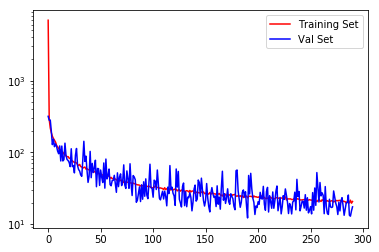

In [6]:
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['loss'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_loss'],color='b', label='Val Set')
pyplot.legend()
#pyplot.ylim(0, 18)
pyplot.yscale('log')

2 Layers 500 components min ~ 0.05 mse and 10% error.
Reduced layers by 1 and added 500 components. 

In [7]:
print(train)
print(test)
print(100*np.mean(perc))

2.0909617689350886
1.9846250588931518
1.9846250588931518


In [8]:
saved_model = build_model()
saved_model.load_weights("NLO/MODEL/uuxg.hdf5")


tic = time.perf_counter()
test_predict = saved_model.predict(poly_test)
toc = time.perf_counter()
print(f"Prediction ran in {toc - tic:0.4f} seconds")


NameError: name 'poly_test' is not defined

###### print(me_predict)

###### 60% error for temp
Scaled by log 0.04469647411690197

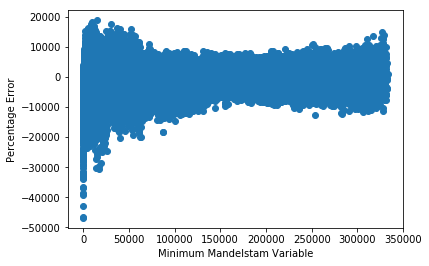

In [12]:
mandel_str = ['1,3','2,3','1,2']
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(mandel_str, mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    #print(sum([1 for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 175000]))
    #print(100*np.mean([perc_error[i] for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 100]))
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    #pyplot.xlim(0,1000000)
    
error_smallest_S(perc, mom_test)

In [8]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test)

x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [9]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
print(len(perc))
grid = griddata((x2, x3), np.abs(perc), (X2i, X3i), method='linear')
print(grid)

332820
[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan 3904.95046519           nan ...           nan
            nan           nan]
 ...
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]]


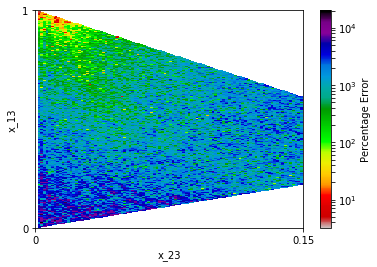

In [10]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 100])
ax.set_xticklabels([0, 0.15])
ax.set_xlim(0,100)
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x_13')
ax.set_xlabel('x_23')

pyplot.savefig('PercentageError.png')